## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
X.isna().any() # проверка на пропуски NaN

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool

In [4]:
X.isnull().values.any() # проверка на пропуски null

False

In [5]:
# cat_features = (X.dtypes == "object").values 
cat_features = X.dtypes == "object" # проверяем по всем столбцам, есть ли в них категориальные значения, они носят тип object
cat_features

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [9]:
neighbours = [1, 3, 5, 10, 15, 25]
data_train, data_test = X_train[['alcohol', 'magnesium']], X_test[['alcohol', 'magnesium']]

scaler = StandardScaler()

scaler.fit(data_train)
data_train_norm = scaler.transform(data_train)
data_test_norm = scaler.transform(data_test)

clfs = []
print('NN\tTrain\tTest')
for k in neighbours:
    cls = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    cls.fit(data_train_norm, y_train)
    y_train_predict = cls.predict(data_train_norm)
    y_test_predict = cls.predict(data_test_norm)
    print(k, '\t', "%.2f"%accuracy_score(y_train_predict, y_train), '\t', "%.2f"%accuracy_score(y_test_predict, y_test))
    clfs.append(cls)

NN	Train	Test
1 	 1.00 	 0.67
3 	 0.81 	 0.78
5 	 0.75 	 0.72
10 	 0.73 	 0.78
15 	 0.73 	 0.80
25 	 0.67 	 0.80


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [10]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

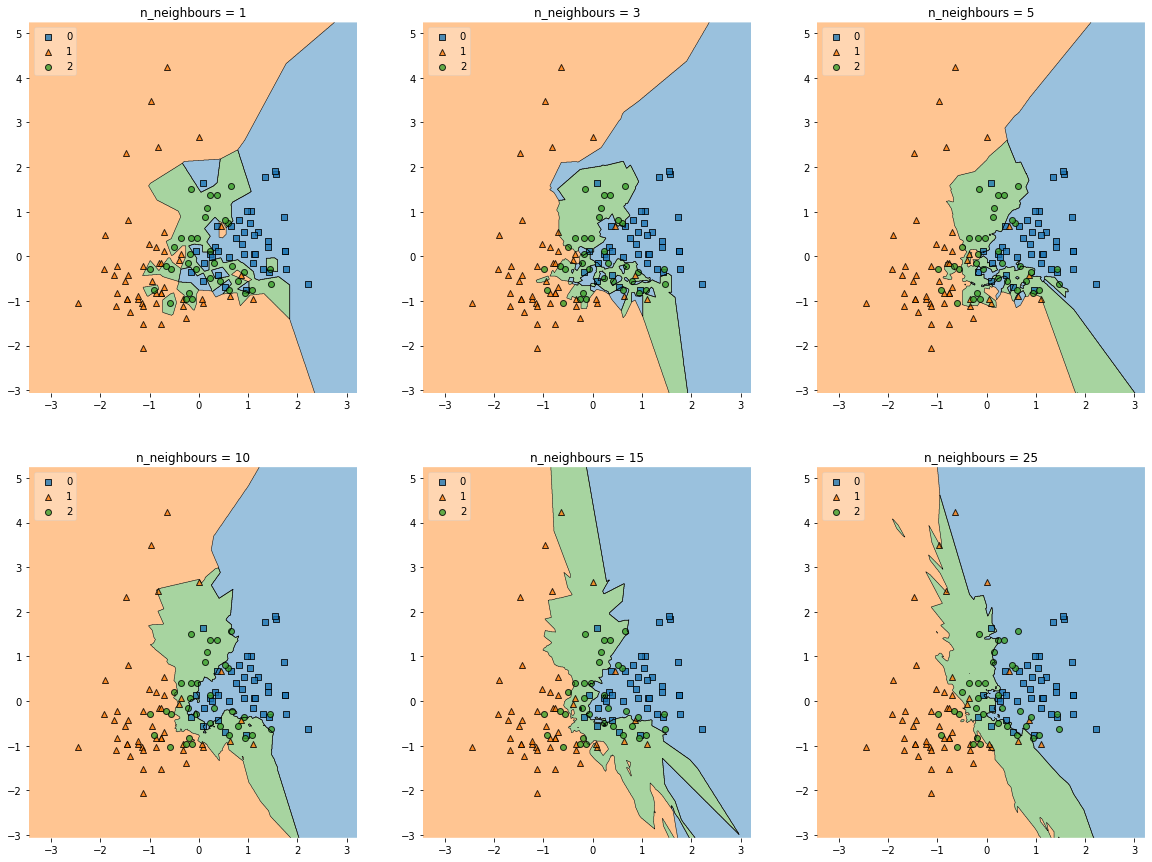

In [12]:
# random seed 0
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(20,15))

labels = [f'n_neighbours = {k}' for k in neighbours]
for clf, lab, grd in zip(clfs, labels, itertools.product([0, 1], [0, 1, 2])):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=data_train_norm, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

        Ответ
Несмотря на неплохие показатели accuracy для к in [1, 3, 5], понятно (и графики в 1.5 это доказывают), что при таких небольших к решающие поверхности будут сильно *разрежены* - для каждого выброса или случайно затесавшегося элемента другого класса будет выделен собственный "островок" внутри поля другого класса, что нелогично и *плохо обобщает*, а наша задача сделать модель *обобщающей*

Если смотреть на резы 1.3, из оставшихся к лучше всего использовать к=15: по accuracy на train показатель лучший из оставшихся, а на test - вообще лучший. Но решающие поверхности при к=15 *не очень логичнны*: там снова есть эти мелкие ненужные островки отличающихся классов, и зеленая поверхность уходит зачем-то вверх, хотя там уже все-таки было бы логичннее сделать рыжую область.

Кажется, что оптимальным было бы использовать **к=10**. При нем решающие поверхности наиболее логичны (как я бы разделила руками), обобщены и наименее разрежены (меньше чем при к=25).

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

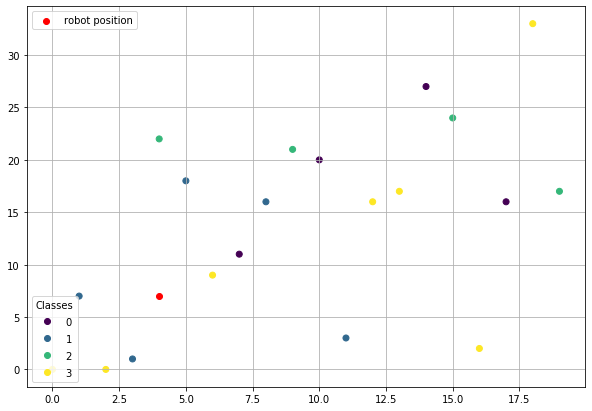

In [13]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        
        # Store the history of movements
        self.trajectory = [initial_position] # <ВАШ КОД ЗДЕСЬ>
        
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k) # <ВАШ КОД ЗДЕСЬ>
        self.knn.fit(landmarks, classes)
        
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}

    
    def move(self):
        decision = np.random.binomial(1, 0.2)
        if decision == 1: # сдвиг вправо вне зависимости от расположения робота
            self.trajectory.append(self.trajectory[-1]+self.mapping[0])
        else:
            move_class = self.knn.predict(self.trajectory[-1].reshape(1,2))
            self.trajectory.append(self.trajectory[-1]+self.mapping[move_class[0]])
        '''
        Calculate new position of the robot and add it to the history
        '''
        
        # <ВАШ КОД ЗДЕСЬ>

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [16]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
#     robot.predict()
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = np.array(robot.trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

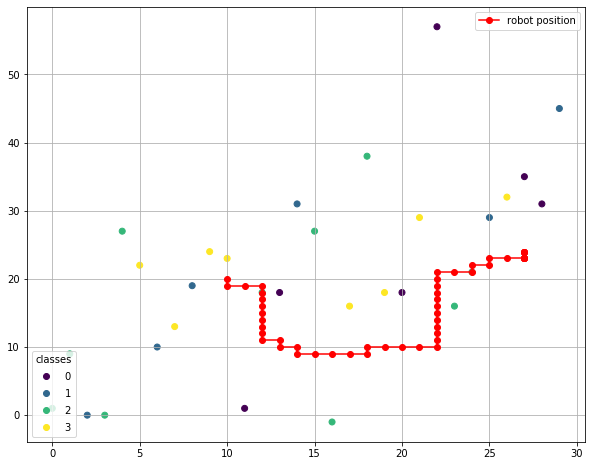

In [17]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

Кажется, что с увеличением К траектория робота становится менее "размашистой": он чаще принимает решения двигаться вверх или вниз (иногда даже влево) и все реже подолгу движется вправо. Это означает, что среди его соседей становится больше экземпляров других классов (логично). 
Приближаясь к К=количество всех точек на плоскости (30), становится ясно, что класс большинства точек - "вверх", так как робот все более настойчиво идет вверх, не считая тех его шагов, в которых он шагает вправо вне зависимости от соседей (так как при К=количество всех точек на плоскости предсказание классификатора будет одинаковым для всех точек - этим предсказанием будет класс большинства).

Если назначить классы меткам осымсленно, например обозначить ими географию реального жилого помещения, то скорее всего в одном месте было бы больше меток одного класса, а у робота было бы больше шансов пройти всю ограниченную этими метками плоскость (как робот-пылесос так или иначе проходит по всей комнате)

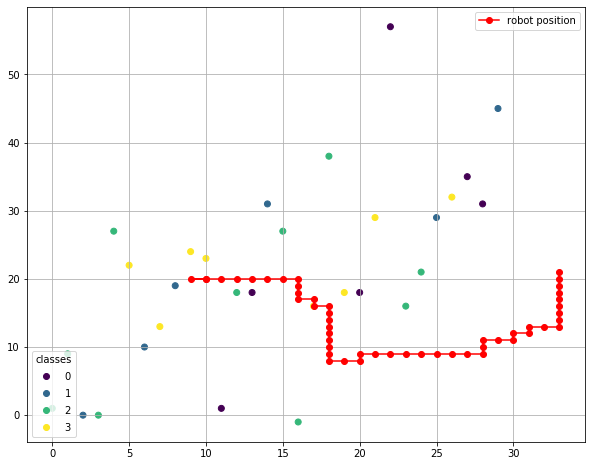

In [18]:
conduct_experiment(x, mean = 3, std = 10, k = 3, n_movements = 50)

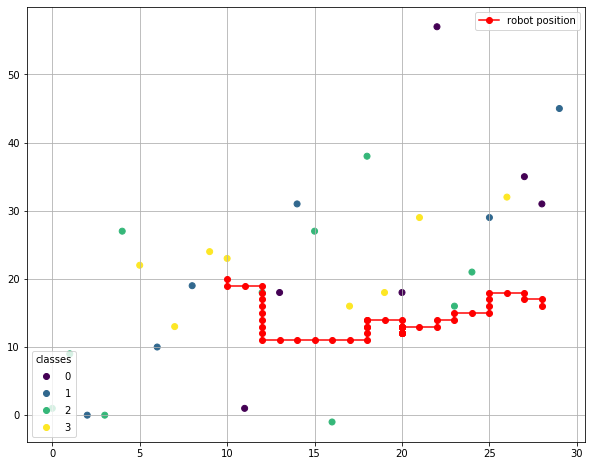

In [19]:
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

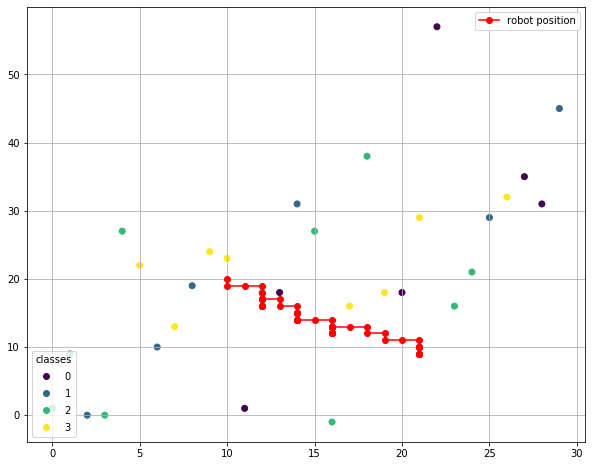

In [20]:
conduct_experiment(x, mean = 3, std = 10, k = 18, n_movements = 50)

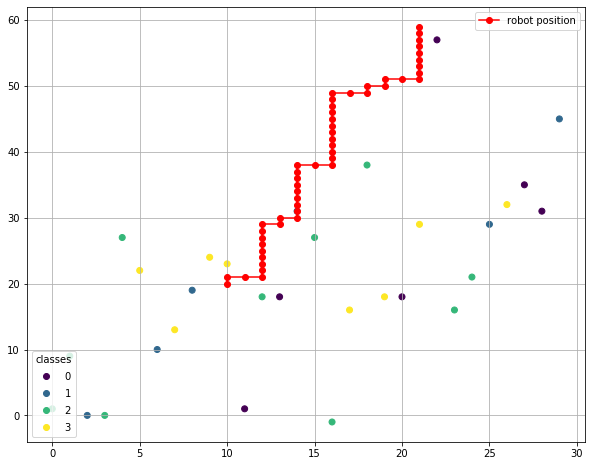

In [21]:
conduct_experiment(x, mean = 3, std = 10, k = 27, n_movements = 50)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [63]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2021/homeworks/hw04-knn_linreg/data/diamonds.csv

--2022-03-16 14:24:34--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2021/homeworks/hw04-knn_linreg/data/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3192560 (3.0M) [text/plain]
Saving to: ‘diamonds.csv’

diamonds.csv        100%[===================>]   3.04M  3.17MB/s    in 1.0s    

2022-03-16 14:24:36 (3.17 MB/s) - ‘diamonds.csv’ saved [3192560/3192560]



In [22]:
diam = pd.read_csv('diamonds.csv')
diam.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [23]:
diam.isna().any()

Unnamed: 0    False
carat         False
cut           False
color         False
clarity       False
depth         False
table         False
price         False
x             False
y             False
z             False
dtype: bool

In [24]:
diam.isnull().values.any()

False

пропусков нет

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [25]:
# столбец 'Unnamed: 0' - это просто индексация данных, начиная с 1, а не с 0, так что эту информацию можо получить из индекса.

diam.drop('Unnamed: 0', axis = 1, inplace=True)
diam.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [26]:
data_numeric = diam.select_dtypes(include=np.number)

In [27]:
data_numeric.corr().sort_values('price', ascending=False)[['price']]
# больше всего на целевую переменную, цену, влияют карат и размер (все три размерности) камня - длина чуть больше, чем ширина с глубиной

,price
price,1.000000
carat,0.921591
x,0.884435
y,0.865421
z,0.861249
table,0.127134
depth,-0.010647


**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [28]:
diam = pd.get_dummies(data=diam, drop_first=True)
diam.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [29]:
X_diam = diam.drop('price', axis=1)
y_diam = diam[['price']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X_diam, y_diam, test_size=0.3, random_state=123)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [30]:
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train_norm = scaler2.transform(X2_train)
X2_test_norm = scaler2.transform(X2_test)


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse

In [32]:
lr = LinearRegression()
lr.fit(X2_train_norm, y2_train)
y_train_predicted = lr.predict(X2_train_norm)
y_test_predicted = lr.predict(X2_test_norm)

print('Train MSE\tTest MSE\n%.2f\t%.2f'%(mse(y2_train, y_train_predicted), mse(y2_test, y_test_predicted)))

Train MSE	Test MSE
1270791.85	1291193.90


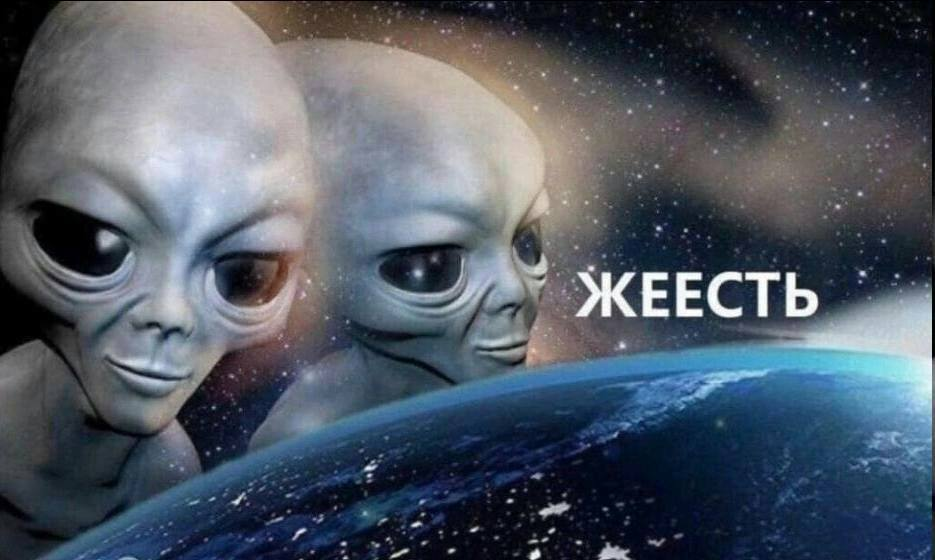

In [33]:
# RMSE
print('Train RMSE\tTest RMSE\n%.2f\t\t%.2f'%(mse(y2_train, y_train_predicted, squared=False), mse(y2_test, y_test_predicted, squared = False)))

Train RMSE	Test RMSE
1127.29		1136.31


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [34]:
params = lr.coef_
weights = pd.DataFrame({col: w for col, w in zip(X2_train.columns, params[0])}, index=['Weight']).T
weights
# вещественные переменные - первые шесть характеристик в таблице:
#   Коэффициент переменных Х и карат (хз что с ним употребляется - число/номер/...) 
#   на два и где-то даже на три (переменная у) порядка больше всех остальных вещественных переменных

,Weight
carat,5307.717343
depth,-90.909302
table,-63.022745
x,-1089.756486
y,0.346573
z,-40.204498
cut_Good,177.312094
cut_Ideal,420.765029
cut_Premium,344.490788
cut_Very Good,311.980757


**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

Стоит сказать, что у меня в модели мультиколлинеарность очень сильно проявилась в начале этого задания из-за OHE: оказалось, что это частая проблема, "Dummy Variable Trap" (веса признаков, получившихся в результате дамми-кодирования, были порядка 10^15, тогда как веса вещественных переменных оставались в рамках 10^3), так что, вызывая pd.get_dummies , мне пришлось поставить параметр drop_first=True, что во многих случаях, включая мой, решает эту проблему.

С одной стороны, среди вещественных переменных неслабую мультиколлинеарность можно было заподозрить еще на этапе вычисления корреляции: с таргетом переменные коррелировали очень сильно - коэффициенты корреляции 4-ех из 6 переменных были > 0.8. С другой, LASSO регрессия уменьшила веса многих переменных (в основном полученых из OHE) на порядок, RIDGE регрессия же почти их не изменила.

Учитывая, что в последнем задании (спойлер) обычная модель линейной регрессии оказалась более эффективной на тестовой выборке, чем LASSO модель с подобранным коэффициентом, скажу, что мультиколлинеарность в изначальной регрессии проявлена несильно.

In [35]:
lasso = Lasso(10).fit(X2_train_norm, y2_train)
params = lasso.coef_
weights = pd.DataFrame({col: w for col, w in zip(X2_train.columns, params)}, index=['Lasso Weights']).T
weights

,Lasso Weights
carat,4825.591889
depth,-100.045814
table,-73.612934
x,-659.976427
y,-0.000000
z,-33.748132
cut_Good,48.466806
cut_Ideal,207.416634
cut_Premium,152.773649
cut_Very Good,136.237880


In [36]:
ridge = Ridge(10)
ridge.fit(X2_train_norm, y2_train)
params = ridge.coef_

weights = pd.DataFrame({col: w for col, w in zip(X2_train.columns, params[0])}, index=['Ridge Weights']).T
weights

,Ridge Weights
carat,5270.623943
depth,-89.294951
table,-63.214765
x,-1049.459601
y,-1.696406
z,-43.543168
cut_Good,177.606753
cut_Ideal,421.414874
cut_Premium,345.135106
cut_Very Good,312.910240


**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

    Ответ
Lasso-регрессия уменьшает веса сильно аггресивнее. 
Она автоматически проводит отбор признаков, строя модель: так как она добавляет к минимизируемому функционалу ошибок сумму абсолютных величин коэффициентов регрессии, заставляя их быть меньше фиксированной величины, многие коэффициенты просто зануляются, таким образом исключая свое влияние на предсказание. Оставшиеся ненулевые коэффициенты считаются "отобранными" алгоритмом признаками, которые остаются в модели. 
Ridge регрессия тоже уменьшает веса коэффициентов, но намного меньше из них доводит до нуля. 


[Text(0, 0, '0.1'),
 Text(0, 0, '1'),
 Text(0, 0, '10'),
 Text(0, 0, '100'),
 Text(0, 0, '200')]

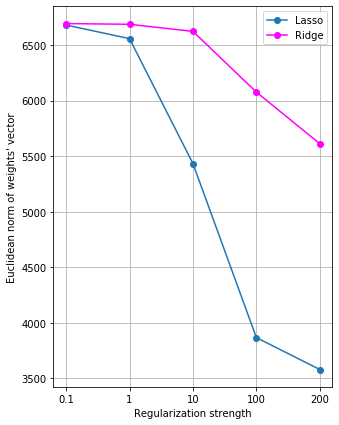

In [61]:
regs = [0.1, 1, 10, 100, 200]
lasso_norms = []
ridge_norms = []
for reg in regs:
    lasso = Lasso(reg).fit(X2_train_norm, y2_train)
    lasso_norms.append(np.linalg.norm(lasso.coef_))
    ridge = Ridge(reg).fit(X2_train_norm, y2_train)
    ridge_norms.append(np.linalg.norm(ridge.coef_))
fig, axes = plt.subplots(figsize=(5,7))
axes.plot(lasso_norms, marker = 'o')
axes.plot(ridge_norms, marker = 'o', color = 'magenta')
axes.set_xticks(ticks=[0, 1, 2, 3, 4])
axes.set_xticklabels(labels=['0.1', '1', '10', '100', '200'])
axes.set_xlabel('Regularization strength')
axes.set_ylabel('Euclidean norm of weights\' vector')
axes.legend(['Lasso', 'Ridge']) 
axes.grid()

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [38]:
from sklearn.linear_model import LassoCV

In [39]:
crossval = LassoCV(n_alphas = 5, alphas=regs, cv=5).fit(X2_train_norm, y2_train.values.ravel())

/Users/zhenyadubnova/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615960188.8187447, tolerance: 47919147.9701415
  tol, rng, random, positive)


In [45]:
cv=pd.DataFrame(crossval.mse_path_, columns =[f'validation {i}' for i in [1,2,3,4,5]], 
                index=[f'𝛼={i}' for i in crossval.alphas_])
cv

,validation 1,validation 2,validation 3,validation 4,validation 5
𝛼=200.0,2.161469e+06,2.127189e+06,2.218278e+06,2.139076e+06,2.133937e+06
𝛼=100.0,1.805084e+06,1.774616e+06,1.833230e+06,1.751819e+06,1.761305e+06
𝛼=10.0,1.373501e+06,1.304373e+06,1.397426e+06,1.291993e+06,1.306897e+06
𝛼=1.0,1.314027e+06,1.235592e+06,1.329421e+06,1.251028e+06,1.250739e+06
𝛼=0.1,1.312842e+06,1.235078e+06,1.382755e+06,1.253364e+06,1.251045e+06


In [46]:
cv.mean(axis=1)

𝛼=200.0    2.155990e+06
𝛼=100.0    1.785211e+06
𝛼=10.0     1.334838e+06
𝛼=1.0      1.276161e+06
𝛼=0.1      1.287017e+06
dtype: float64

    Минимальная ошибка -> наибольшее качество:
**𝛼 = 1**

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [47]:
lasso = Lasso(1).fit(X2_train_norm, y2_train)
weights = pd.DataFrame({col: w for col, w in zip(X2_train.columns, lasso.coef_)}, index=['Weight']).T
weights

,Weight
carat,5259.479121
depth,-91.836082
table,-64.079225
x,-1046.564711
y,-0.000000
z,-39.469813
cut_Good,164.532145
cut_Ideal,399.618347
cut_Premium,325.477093
cut_Very Good,294.566353


In [54]:
lasso = Lasso(100).fit(X2_train_norm, y2_train)
weights = pd.DataFrame({col: w for col, w in zip(X2_train.columns, lasso.coef_)}, index=['Weight']).T
weights

,Weight
carat,3824.519680
depth,-24.631968
table,-0.000000
x,0.000000
y,0.000000
z,0.000000
cut_Good,-0.000000
cut_Ideal,40.294900
cut_Premium,0.000000
cut_Very Good,0.000000


Неинформативные признаки по мнению Lasso-алгоритма - те, что он занулил. Он провел автоматический отбор признаков, выделив наиболее и наименее информативные

    С регуляризатором 𝛼 = 100:
Заметим, что, во-первых занулились (=посчитались неинформативными) размерности камня: x, y, z. Возможно это случилось из-за того, что каждый из них по отдельности на цену почти не влияет, в отличие от их соотношения друг с другом - это параметр depth, который не занулился. То есть depth= func(x, y, z) и влияет на предсказание цены.

Так же занулились все качества огранки, кроме "идеального" - то есть больше всего на цену влияет только идеально ограненный бриллиант (максимальный уровень из возможных). Возможно потому что огранка - дело трудное и высокооплачиваемое, так что если огранка идеальная, то есть сделана профессионалом, это сразу сильно завышает цену. Ну и, думаю, идеально ограненный бриллиант выглядит сильно лучше остальных категроий, возможно даже невооруженным глазом, так что цену на него выставляют сильно больше - потому что такие камни себе покупают те, кто может это позволить.

Что касается цветов (варьируются from J (worst) to D (best)), то видно, что плохие цвета на цену оказывают больше отрицательного влияния, чем хорошие - положительного (занулились коэффициенты при 4-ех наилучших цветах, тогда как три оставшихся оказывают тем хуже влияние, чем хуже цвет). Возможно потому что плохой цвет бриллианта различить легче, чем степени хорошего цвета (не разбираюсь, но возможно...), или потому что бриллиантов "плохих" цветов на рынке больше, так как добыть их легче и встречаются в природе они чаще, чем чистые.

    С регуляризатором 𝛼 = 1:

Получается сильно менее интересно: неинформативным регрессия сочла только один признак, у (только он занулился). Смысловое объяснение все то же: так как остались незануленными х, z и depth, то *у* теряет свое индивидуальное влияние на цену, так как depth = func(x, y, z). 

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [49]:
lr_test_predicted = lr.predict(X2_test_norm)
lasso_test_predicted = lasso.predict(X2_test_norm)
print(f'Linear regression without reg: {round(mse(y2_test, lr_test_predicted), 2)}'+
    f'\nLasso regression with 𝛼 = 1: {round(mse(y2_test, lasso_test_predicted), 2)}')

Linear regression without reg: 1291193.9
Lasso regression with 𝛼 = 1: 1290690.88


**зато теперь понятно, почему раньше модель без регуляризации была намного лучше LASSO! а то ошибка на LASSO-регрессии с 𝛼 = 100 прямо сильно больше, чем ошибка на обычной регрессии)))**

Ошибка на LASSO-регрессии с 𝛼 = 1 хоть очень несильно, но все-таки меньше, чем на обычной линейной регрессии. Так как для предсказаний лучше использовать модель с меньшей MSЕ, то в данном случае стоит использовать LASSO-регрессию. 

Учитывая, что разница в их MSE ~ 500, что является очень маленькой разницей для таких больших MSE (~ 0,04%), то трудно говорить о каком-то значительном объяснении, почему одна модель оказалась лучше другой - сравнивая по MSE на тестовой выборке, они почти одинаковые.

Если сравнить коэффициенты этих двух регрессий, то видно, что в LASSO-регрессии кроме зануления коэффициента при у, все веса уменьшились в основном не более, чем на 10-30. Наибольшее уменьшение (>100) коснулись переменных Clarity. Возможно, связано с этим - у больше не влияет на предсказание, а Clarity влияет чуть меньше. Возможно, эта разница в 500 - это то, насколько обычная лин регрессия успела переобучиться, а LASSO этому помешал. вообще возможно все